<a href="https://colab.research.google.com/github/farshid101/Thesis-2024/blob/main/sentiment_analysis_bangla_bert.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current

In [ ]:
#Dataset
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv"

--2024-10-06 05:43:58--  https://raw.githubusercontent.com/DeepProgram/random/main/blp23_sentiment_test_with_label.tsv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1626269 (1.6M) [text/plain]
Saving to: ‘blp23_sentiment_test_with_label.tsv’

blp23_sentiment_tes 100%[===================>]   1.55M  --.-KB/s    in 0.05s   

2024-10-06 05:43:58 (34.3 MB/s) - ‘blp23_sentiment_test_with_label.tsv’ saved [1626269/1626269]



In [ ]:
!pip install transformers
!pip install datasets
!pip install evaluate
!pip install --upgrade accelerate

INFO: pip is looking at multiple versions of multiprocess to determine which version is compatible with other requirements. This could take a while.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 471.6/471.6 kB 13.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 10.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 9.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 15.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 3.3 MB/s eta 0:00:00


In [ ]:
import logging
import os
import random
import sys
from dataclasses import dataclass, field
from typing import Optional
import pandas as pd
import datasets
import evaluate
import numpy as np
from datasets import load_dataset, Dataset, DatasetDict
import torch

import transformers
from transformers import (
    AutoConfig,
    AutoModelForSequenceClassification,
    AutoTokenizer,
    DataCollatorWithPadding,
    EvalPrediction,
    HfArgumentParser,
    PretrainedConfig,
    Trainer,
    TrainingArguments,
    default_data_collator,
    set_seed,
)
from transformers.trainer_utils import get_last_checkpoint
from transformers.utils import check_min_version, send_example_telemetry
from transformers.utils.versions import require_version


logger = logging.getLogger(__name__)

logging.basicConfig(
    format="%(asctime)s - %(levelname)s - %(name)s - %(message)s",
    datefmt="%m/%d/%Y %H:%M:%S",
    handlers=[logging.StreamHandler(sys.stdout)],
)

In [ ]:
!wget "https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip"

--2024-10-06 05:45:32--  https://raw.githubusercontent.com/DeepProgram/random/main/sentiment_analysis_data.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2645403 (2.5M) [application/zip]
Saving to: ‘sentiment_analysis_data.zip’

sentiment_analysis_ 100%[===================>]   2.52M  --.-KB/s    in 0.05s   

2024-10-06 05:45:32 (49.3 MB/s) - ‘sentiment_analysis_data.zip’ saved [2645403/2645403]



In [ ]:
!unzip -o /kaggle/working/sentiment_analysis_data.zip

unzip:  cannot find or open /kaggle/working/sentiment_analysis_data.zip, /kaggle/working/sentiment_analysis_data.zip.zip or /kaggle/working/sentiment_analysis_data.zip.ZIP.


In [ ]:
train_file = '/content/Mega Test Data.xlsx'
validation_file = '/content/Mega Test Data.xlsx'
test_file = '/content/Mega Test Data.xlsx'

In [ ]:
training_args = TrainingArguments(
    learning_rate=2e-5,
    num_train_epochs=1,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    output_dir="./bertBaseMultilingualNew/",
    overwrite_output_dir=True,
    remove_unused_columns=False,
    local_rank= 1,
    load_best_model_at_end=True,
    save_total_limit=2,
    save_strategy="no"
)

max_train_samples = None
max_eval_samples=None
max_predict_samples=None
max_seq_length = 512
batch_size = 16

[INFO|training_args.py:2100] 2024-10-06 06:02:18,309 >> PyTorch: setting up devices
[INFO|training_args.py:1788] 2024-10-06 06:02:18,331 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).


In [ ]:
transformers.utils.logging.set_verbosity_info()

log_level = training_args.get_process_log_level()
logger.setLevel(log_level)
datasets.utils.logging.set_verbosity(log_level)
transformers.utils.logging.set_verbosity(log_level)
transformers.utils.logging.enable_default_handler()
transformers.utils.logging.enable_explicit_format()
logger.warning(
    f"Process rank: {training_args.local_rank}, device: {training_args.device}, n_gpu: {training_args.n_gpu}"
    + f" distributed training: {bool(training_args.local_rank != -1)}, 16-bits training: {training_args.fp16}"
)
logger.info(f"Training/evaluation parameters {training_args}")

INFO:__main__:Training/evaluation parameters TrainingArguments(
_n_gpu=1,
accelerator_config={'split_batches': False, 'dispatch_batches': None, 'even_batches': True, 'use_seedable_sampler': True, 'non_blocking': False, 'gradient_accumulation_kwargs': None, 'use_configured_state': False},
adafactor=False,
adam_beta1=0.9,
adam_beta2=0.999,
adam_epsilon=1e-08,
auto_find_batch_size=False,
batch_eval_metrics=False,
bf16=False,
bf16_full_eval=False,
data_seed=None,
dataloader_drop_last=False,
dataloader_num_workers=0,
dataloader_persistent_workers=False,
dataloader_pin_memory=True,
dataloader_prefetch_factor=None,
ddp_backend=None,
ddp_broadcast_buffers=None,
ddp_bucket_cap_mb=None,
ddp_find_unused_parameters=None,
ddp_timeout=1800,
debug=[],
deepspeed=None,
disable_tqdm=False,
dispatch_batches=None,
do_eval=False,
do_predict=False,
do_train=False,
eval_accumulation_steps=None,
eval_delay=0,
eval_do_concat_batches=True,
eval_on_start=False,
eval_steps=None,
eval_strategy=no,
eval_use_gather_

In [ ]:
model_name = 'sagorsarker/bangla-bert-base'

In [ ]:
set_seed(training_args.seed)

In [ ]:
punctuations = ["|","‘",">","<","*",   "।", ",", ";", ":", "?", "!", "'", ".", "\"", "-",
                "[", "]", "{", "}", "(", ")", '–', "—", "―", "~"]

def remove_url(word):
    return word.split("http")[0].strip()

def extreme_process(word):
    word_list = [word]
    splitter_list = ["**","*", "…", "-"]

    for i in splitter_list:
        if i in word:
            temp_list = word.split(i)
            word_list = list(filter(lambda x:x.strip() != "", temp_list))
            return word_list
    return word_list


def process_word(word):
    word = word.strip()
    if len(word) == 0:
        return []
    elif len(word) == 1:
        if word not in punctuations:
            return [word]
        else:
            return []
    else:
        word = remove_url(word)

        if len(word) == 0:
            return []
        elif len(word) == 1:
            if word in punctuations:
                return []
            else:
                return [word]
        else:
            if word[0] in punctuations:
                word = word[1:]
            if word[-1] in punctuations:
                word = word[:-1]

            word = extreme_process(word)

            return word

In [ ]:
# l2id = {'Positive': 2, 'Neutral': 1, 'Negative': 0}
# train_df = pd.read_csv(train_file, sep='\t')
# #print(train_df.head())
# train_df.head()


import pandas as pd

l2id = {'positive': 2, 'neutral': 1, 'negative': 0}
# Load the Excel file instead of a CSV file
train_df = pd.read_excel(train_file)  # Replace with your actual file path
#print(train_df.head())
train_df.head()


,text,label
0,মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...,positive
1,আমরা করে দেখিয়েছি বিশ্বকে,neutral
2,আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...,positive
3,এখন কান্দ টাকা নাই,positive
4,দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...,neutral


In [ ]:
train_df.head()

,text,label
0,মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...,positive
1,আমরা করে দেখিয়েছি বিশ্বকে,neutral
2,আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...,positive
3,এখন কান্দ টাকা নাই,positive
4,দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...,neutral


In [ ]:
for index, row in train_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    train_df.at[index, "text"] = " ".join(processed_word_list)

In [ ]:
train_df['label'] = train_df['label'].map(l2id)
train_df.head()

,text,label
0,মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...,2
1,আমরা করে দেখিয়েছি বিশ্বকে,1
2,আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...,2
3,এখন কান্দ টাকা নাই,2
4,দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...,1


In [ ]:
train_df = Dataset.from_pandas(train_df)
print(train_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 1927
})


In [ ]:
validation_df = pd.read_excel(validation_file)
validation_df=validation_df[:1000]
for index, row in validation_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    validation_df.at[index, "text"] = " ".join(processed_word_list)

In [ ]:
validation_df.head()

,text,label
0,মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...,positive
1,আমরা করে দেখিয়েছি বিশ্বকে,neutral
2,আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...,positive
3,এখন কান্দ টাকা নাই,positive
4,দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...,neutral


In [ ]:
validation_df['label'] = validation_df['label'].map(l2id)
validation_df = Dataset.from_pandas(validation_df)
print(validation_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})


In [ ]:
old_test_df = pd.read_excel(validation_file)
old_test_df=old_test_df[:1000]
old_test_df=old_test_df.drop(columns=['label'])
print(old_test_df.head())
print(len(old_test_df))

                                                text
0  মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...
1                         আমরা করে দেখিয়েছি বিশ্বকে
2  আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...
3                                 এখন কান্দ টাকা নাই
4  দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...
1000


In [ ]:
test_df = pd.read_excel(validation_file)
test_df=test_df[:1000]

print(test_df.head())
print(len(test_df))

                                                text     label
0  মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...  positive
1                         আমরা করে দেখিয়েছি বিশ্বকে   neutral
2  আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...  positive
3                                 এখন কান্দ টাকা নাই  positive
4  দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...   neutral
1000


In [ ]:
test_df['label'] = test_df['label'].map(l2id)
print(test_df)

                                                  text  label
0    মাননীয় প্রধানমন্ত্রী জননেত্রী দেশরত্ন শেখ হাস...      2
1                           আমরা করে দেখিয়েছি বিশ্বকে      1
2    আরিচা নগরবাড়ি রুটে ৩৩০০০ ভোল্টেজ বিদ্যুৎ সঞ্চ...      2
3                                   এখন কান্দ টাকা নাই      2
4    দেশ থেকে সিমেন্ট কিনলে তো আর পনের হাজার টাকা ব...      1
..                                                 ...    ...
995                                              Qqqqq      1
996  পদ্মা সেতু খুবই দরকার, আর ট্রাফিক ব্যাবস্থা খা...      0
997                  Allah sobaike jannath nosib koron      1
998                                                 U+      1
999                                              Ameen      1

[1000 rows x 2 columns]


In [ ]:
for index, row in test_df.iterrows():
    unprocessed_spliited_word = row["text"].split(" ")
    processed_word_list = []
    for i in unprocessed_spliited_word:
        processed_word_list += process_word(i)
    test_df.at[index, "text"] = " ".join(processed_word_list)

In [ ]:
test_df = Dataset.from_pandas(test_df)
print(test_df)

Dataset({
    features: ['text', 'label'],
    num_rows: 1000
})


In [ ]:
data_files = {"train": train_df, "validation": validation_df, "test": test_df}
for key in data_files.keys():
    logger.info(f"loading a local file for {key}")

INFO:__main__:loading a local file for train
INFO:__main__:loading a local file for validation
INFO:__main__:loading a local file for test


In [ ]:
raw_datasets = DatasetDict(
    {"train": train_df, "validation": validation_df, "test": test_df}
)

In [ ]:
print(raw_datasets)

DatasetDict({
    train: Dataset({
        features: ['text', 'label'],
        num_rows: 1927
    })
    validation: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
    test: Dataset({
        features: ['text', 'label'],
        num_rows: 1000
    })
})


In [ ]:
label_list = raw_datasets["train"].unique("label")
print(label_list)

[2, 1, 0]


In [ ]:
label_list.sort()  # sort the labels for determine
print(label_list)

[0, 1, 2]


In [ ]:
num_labels = len(label_list)
print(num_labels)

3


In [ ]:
config = AutoConfig.from_pretrained(
    model_name,
    num_labels=num_labels,
    finetuning_task=None,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/491 [00:00<?, ?B/s]

[INFO|configuration_utils.py:733] 2024-10-06 06:15:33,414 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:800] 2024-10-06 06:15:33,433 >> Model config BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "id2label": {
    "0": "LABEL_0",
    "1": "LABEL_1",
    "2": "LABEL_2"
  },
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "label2id": {
    "LABEL_0": 0,
    "LABEL_1": 1,
    "LABEL_2": 2
  },
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transfo

In [ ]:
tokenizer = AutoTokenizer.from_pretrained(
    model_name,
    cache_dir=None,
    use_fast=True,
    revision="main",
    use_auth_token=None,
)

[INFO|tokenization_auto.py:683] 2024-10-06 06:15:49,012 >> Could not locate the tokenizer configuration file, will try to use the model config instead.
[INFO|configuration_utils.py:733] 2024-10-06 06:15:49,098 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:800] 2024-10-06 06:15:49,100 >> Model config BertConfig {
  "_name_or_path": "sagorsarker/bangla-bert-base",
  "architectures": [
    "BertForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "classifier_dropout": null,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 768,
  "initializer_range": 0.02,
  "intermediate_size": 3072,
  "layer_norm_eps": 1e-12,
  "max_position_embeddings": 512,
  "model_type": "bert",
  "num_attention_heads": 12,
  "num_hidden_layers": 12,
  "pad_token_id": 0,
  "position_embedding_type": "absolute",
  "transform

vocab.txt:   0%|          | 0.00/2.24M [00:00<?, ?B/s]

[INFO|tokenization_utils_base.py:2269] 2024-10-06 06:15:49,800 >> loading file vocab.txt from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/vocab.txt
[INFO|tokenization_utils_base.py:2269] 2024-10-06 06:15:49,801 >> loading file tokenizer.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-10-06 06:15:49,803 >> loading file added_tokens.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-10-06 06:15:49,805 >> loading file special_tokens_map.json from cache at None
[INFO|tokenization_utils_base.py:2269] 2024-10-06 06:15:49,806 >> loading file tokenizer_config.json from cache at None
[INFO|configuration_utils.py:733] 2024-10-06 06:15:49,808 >> loading configuration file config.json from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/config.json
[INFO|configuration_utils.py:800] 2024-10-06 06:15:49,

In [ ]:
model = AutoModelForSequenceClassification.from_pretrained(
    model_name,
    from_tf=bool(".ckpt" in model_name),
    config=config,
    cache_dir=None,
    revision="main",
    use_auth_token=None,
    ignore_mismatched_sizes=False,
)

model.safetensors:   0%|          | 0.00/660M [00:00<?, ?B/s]

[INFO|modeling_utils.py:3678] 2024-10-06 06:16:03,633 >> loading weights file model.safetensors from cache at /root/.cache/huggingface/hub/models--sagorsarker--bangla-bert-base/snapshots/875aa80a42ec196c16bd931ae5d85ad949f58b16/model.safetensors
[INFO|modeling_utils.py:4497] 2024-10-06 06:16:03,810 >> Some weights of the model checkpoint at sagorsarker/bangla-bert-base were not used when initializing BertForSequenceClassification: ['cls.predictions.bias', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.bias', 'cls.seq_relationship.weight']
- This IS expected if you are initializing BertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForSequen

In [ ]:
non_label_column_names = [name for name in raw_datasets["train"].column_names if name != "label"]
print(non_label_column_names)

['text']


In [ ]:
sentence_key= non_label_column_names[0]
print(sentence_key)

text


In [ ]:
padding = "max_length"
label_to_id = None

if (model.config.label2id != PretrainedConfig(num_labels=num_labels).label2id):
    # Some have all caps in their config, some don't.
    label_name_to_id = {k.lower(): v for k, v in model.config.label2id.items()}
    if sorted(label_name_to_id.keys()) == sorted(label_list):
        label_to_id = {i: int(label_name_to_id[label_list[i]]) for i in range(num_labels)}
    else:
        logger.warning(
            "Your model seems to have been trained with labels, but they don't match the dataset: ",
            f"model labels: {sorted(label_name_to_id.keys())}, dataset labels: {sorted(label_list)}."
            "\nIgnoring the model labels as a result.",)


if label_to_id is not None:
    model.config.label2id = label_to_id
    model.config.id2label = {id: label for label, id in config.label2id.items()}


if 128 > tokenizer.model_max_length:
    logger.warning(
        f"The max_seq_length passed ({128}) is larger than the maximum length for the"
        f"model ({tokenizer.model_max_length}). Using max_seq_length={tokenizer.model_max_length}.")


max_seq_length = min(128, tokenizer.model_max_length)
print(max_seq_length)

128


In [ ]:
def preprocess_function(examples):
    # Tokenize the texts
    args = (
        (examples[sentence_key],))
    result = tokenizer(*args, padding=padding, max_length=max_seq_length, truncation=True)

    # Map labels to IDs (not necessary for GLUE tasks)
    if label_to_id is not None and "label" in examples:
        result["label"] = [(label_to_id[l] if l != -1 else -1) for l in examples["label"]]
    return result

In [ ]:
raw_datasets = raw_datasets.map(
    preprocess_function,
    batched=True,
    load_from_cache_file=True,
    desc="Running tokenizer on dataset",
)

Running tokenizer on dataset:   0%|          | 0/1927 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

Running tokenizer on dataset:   0%|          | 0/1000 [00:00<?, ? examples/s]

In [ ]:
if "train" not in raw_datasets:
    raise ValueError("requires a train dataset")

In [ ]:
train_dataset = raw_datasets["train"]
print(train_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1927
})


In [ ]:
if "validation" not in raw_datasets:
    raise ValueError("requires a validation dataset")

In [ ]:
eval_dataset = raw_datasets["validation"]
print(eval_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


In [ ]:
print(max_eval_samples)

None


In [ ]:
if max_eval_samples is not None:
    max_eval_samples_n = min(len(eval_dataset), max_eval_samples)
    eval_dataset = eval_dataset.select(range(max_eval_samples_n))

In [ ]:
if "test" not in raw_datasets and "test_matched" not in raw_datasets:
    raise ValueError("requires a test dataset")

In [ ]:
predict_dataset = raw_datasets["test"]
print(predict_dataset)

Dataset({
    features: ['text', 'label', 'input_ids', 'token_type_ids', 'attention_mask'],
    num_rows: 1000
})


In [ ]:
print(max_predict_samples)

None


In [ ]:
if max_predict_samples is not None:
    max_predict_samples_n = min(len(predict_dataset), max_predict_samples)
    predict_dataset = predict_dataset.select(range(max_predict_samples_n))

In [ ]:
for index in random.sample(range(len(train_dataset)), 3):
    logger.info(f"Sample {index} of the training set: {train_dataset[index]}.")

INFO:__main__:Sample 1309 of the training set: {'text': 'সেতুতে অটো ডিটেকক্টর লাগালেইত পারে', 'label': 1, 'input_ids': [101, 2118, 63129, 2094, 51705, 2094, 2395, 80346, 17338, 22146, 2046, 18567, 41821, 2083, 102, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1

In [ ]:
metric = evaluate.load("accuracy")

In [ ]:
def calculate_micro_f1_score(true_positives, false_positives, false_negatives):
    total_tp = sum(true_positives)
    total_fp = sum(false_positives)
    total_fn = sum(false_negatives)

    micro_precision = total_tp / (total_tp + total_fp + 1e-9)
    micro_recall = total_tp / (total_tp + total_fn + 1e-9)

    micro_f1 = 2 * (micro_precision * micro_recall) / (micro_precision + micro_recall + 1e-9)

    return micro_f1

In [ ]:
def compute_metrics(p: EvalPrediction):
    preds = p.predictions[0] if isinstance(p.predictions, tuple) else p.predictions
    preds = np.argmax(preds, axis=1)

    labels = p.label_ids
    # Initialize dictionaries to store TP, FP, and FN for each class
    true_positives = {label: 0 for label in range(num_labels)}
    false_positives = {label: 0 for label in range(num_labels)}
    false_negatives = {label: 0 for label in range(num_labels)}

    for label, pred in zip(labels, preds):
        for class_id in range(num_labels):
            if class_id == label and class_id == pred:
                true_positives[class_id] += 1
            elif class_id != label and class_id == pred:
                false_positives[class_id] += 1
            elif class_id == label and class_id != pred:
                false_negatives[class_id] += 1

    return {
        "micro_f1_score": calculate_micro_f1_score(
            list(true_positives.values()), list(false_positives.values()), list(false_negatives.values())
        ),
        "accuracy": (preds == p.label_ids).astype(np.float32).mean().item()
    }


In [ ]:
data_collator = default_data_collator

In [ ]:
import os
os.environ["WANDB_DISABLED"] = "true"

In [ ]:
from transformers import BertTokenizer, BertForSequenceClassification, Trainer, TrainingArguments
training_args = TrainingArguments(
    output_dir="./output",
    evaluation_strategy="steps",  # Changed to "steps"
    logging_dir="./logs",
    per_device_train_batch_size=8,
    per_device_eval_batch_size=8,
    learning_rate=2e-5,
    num_train_epochs=3,
    weight_decay=0.01,
    save_total_limit=3,  # Limit the number of saved checkpoints
    load_best_model_at_end=True,
)

# Initialize the Trainer
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=eval_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
)

# Perform cross-validation
results = trainer.evaluate()
print(results)

/usr/local/lib/python3.10/dist-packages/transformers/training_args.py:1525: FutureWarning: `evaluation_strategy` is deprecated and will be removed in version 4.46 of 🤗 Transformers. Use `eval_strategy` instead
  warnings.warn(
[INFO|training_args.py:1565] 2024-10-06 06:18:33,011 >> using `logging_steps` to initialize `eval_steps` to 500
[INFO|training_args.py:2100] 2024-10-06 06:18:33,013 >> PyTorch: setting up devices
[INFO|training_args.py:1788] 2024-10-06 06:18:33,033 >> The default value for the training argument `--report_to` will change in v5 (from all installed integrations to none). In v5, you will need to use `--report_to all` to get the same behavior as now. You should start updating your code and make this info disappear :-).
[WARNING|integration_utils.py:100] 2024-10-06 06:18:33,036 >> Using the `WANDB_DISABLED` environment variable is deprecated and will be removed in v5. Use the --report_to flag to control the integrations used for logging result (for instance --report_to

{'eval_loss': 1.2068068981170654, 'eval_model_preparation_time': 0.0041, 'eval_micro_f1_score': 0.214999999499785, 'eval_accuracy': 0.2150000035762787, 'eval_runtime': 8.1159, 'eval_samples_per_second': 123.216, 'eval_steps_per_second': 15.402}


In [ ]:
train_result = trainer.train()

[INFO|trainer.py:811] 2024-10-06 06:18:49,289 >> The following columns in the training set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:2134] 2024-10-06 06:18:49,304 >> ***** Running training *****
[INFO|trainer.py:2135] 2024-10-06 06:18:49,305 >>   Num examples = 1,927
[INFO|trainer.py:2136] 2024-10-06 06:18:49,307 >>   Num Epochs = 3
[INFO|trainer.py:2137] 2024-10-06 06:18:49,310 >>   Instantaneous batch size per device = 8
[INFO|trainer.py:2140] 2024-10-06 06:18:49,311 >>   Total train batch size (w. parallel, distributed & accumulation) = 8
[INFO|trainer.py:2141] 2024-10-06 06:18:49,313 >>   Gradient Accumulation steps = 1
[INFO|trainer.py:2142] 2024-10-06 06:18:49,313 >>   Total optimization steps = 723
[INFO|trainer.py:2143] 2024-10-06 06:18:49,315 >>   Number of trainable parameters = 164,398,851

Step,Training Loss,Validation Loss,Model Preparation Time,Micro F1 Score,Accuracy
500,0.830000,0.577453,0.004100,0.734000,0.734000


[INFO|trainer.py:811] 2024-10-06 06:20:39,194 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-06 06:20:39,199 >> 
***** Running Evaluation *****
[INFO|trainer.py:3821] 2024-10-06 06:20:39,200 >>   Num examples = 1000
[INFO|trainer.py:3824] 2024-10-06 06:20:39,203 >>   Batch size = 8


[INFO|trainer.py:3503] 2024-10-06 06:20:46,808 >> Saving model checkpoint to ./output/checkpoint-500
[INFO|configuration_utils.py:472] 2024-10-06 06:20:46,812 >> Configuration saved in ./output/checkpoint-500/config.json
[INFO|modeling_utils.py:2799] 2024-10-06 06:20:51,353 >> Model weights saved in ./output/checkpoint-500/model.safetensors
[INFO|tokenization_utils_base.py:2684] 2024-10-06 06:20:51,359 >> tokenizer config file saved in ./output/checkpoint-500/tokenizer_config.json
[INFO|tokenization_utils_base.py:2693] 2024-10-06 06:20:51,361 >> Special tokens file saved in ./output/checkpoint-500/special_tokens_map.json
[INFO|trainer.py:3503] 2024-10-06 06:21:52,343 >> Saving model checkpoint to ./output/checkpoint-723
[INFO|configuration_utils.py:472] 2024-10-06 06:21:52,347 >> Configuration saved in ./output/checkpoint-723/config.json
[INFO|modeling_utils.py:2799] 2024-10-06 06:22:00,042 >> Model weights saved in ./output/checkpoint-723/model.safetensors
[INFO|tokenization_utils_bas

In [ ]:
metrics = train_result.metrics
max_train_samples = (
    max_train_samples if max_train_samples is not None else len(train_dataset)
)
metrics["train_samples"] = min(max_train_samples, len(train_dataset))

In [ ]:
trainer.save_model()
trainer.log_metrics("train", metrics)
trainer.save_metrics("train", metrics)
trainer.save_state()

[INFO|trainer.py:3503] 2024-10-06 06:22:28,582 >> Saving model checkpoint to ./output
[INFO|configuration_utils.py:472] 2024-10-06 06:22:28,586 >> Configuration saved in ./output/config.json
[INFO|modeling_utils.py:2799] 2024-10-06 06:22:31,917 >> Model weights saved in ./output/model.safetensors
[INFO|tokenization_utils_base.py:2684] 2024-10-06 06:22:31,924 >> tokenizer config file saved in ./output/tokenizer_config.json
[INFO|tokenization_utils_base.py:2693] 2024-10-06 06:22:31,927 >> Special tokens file saved in ./output/special_tokens_map.json


***** train metrics *****
  epoch                    =        3.0
  total_flos               =   354149GF
  train_loss               =      0.755
  train_runtime            = 0:03:23.82
  train_samples            =       1927
  train_samples_per_second =     28.362
  train_steps_per_second   =      3.547


In [ ]:
logger.info("*** Evaluate ***")

metrics = trainer.evaluate(eval_dataset=eval_dataset)

max_eval_samples = (
    max_eval_samples if max_eval_samples is not None else len(eval_dataset)
)
metrics["eval_samples"] = min(max_eval_samples, len(eval_dataset))

trainer.log_metrics("eval", metrics)
trainer.save_metrics("eval", metrics)

INFO:__main__:*** Evaluate ***
[INFO|trainer.py:811] 2024-10-06 06:22:42,115 >> The following columns in the evaluation set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-06 06:22:42,129 >> 
***** Running Evaluation *****
[INFO|trainer.py:3821] 2024-10-06 06:22:42,130 >>   Num examples = 1000
[INFO|trainer.py:3824] 2024-10-06 06:22:42,132 >>   Batch size = 8


***** eval metrics *****
  epoch                       =        3.0
  eval_accuracy               =      0.734
  eval_loss                   =     0.5775
  eval_micro_f1_score         =      0.734
  eval_model_preparation_time =     0.0041
  eval_runtime                = 0:00:07.22
  eval_samples                =       1000
  eval_samples_per_second     =    138.337
  eval_steps_per_second       =     17.292


In [ ]:
from sklearn.metrics import accuracy_score
predictions = trainer.predict(predict_dataset).predictions
predicted_labels = predictions.argmax(axis=1)
actual_labels = predict_dataset['label']
accuracy = accuracy_score(actual_labels, predicted_labels)
print("Test Accuracy:", accuracy)

[INFO|trainer.py:811] 2024-10-06 06:23:05,907 >> The following columns in the test set don't have a corresponding argument in `BertForSequenceClassification.forward` and have been ignored: text. If text are not expected by `BertForSequenceClassification.forward`,  you can safely ignore this message.
[INFO|trainer.py:3819] 2024-10-06 06:23:05,913 >> 
***** Running Prediction *****
[INFO|trainer.py:3821] 2024-10-06 06:23:05,915 >>   Num examples = 1000
[INFO|trainer.py:3824] 2024-10-06 06:23:05,917 >>   Batch size = 8


Test Accuracy: 0.734


In [ ]:
import numpy as np
from sklearn.metrics import classification_report, f1_score, precision_score, recall_score


true_labels = predict_dataset["label"]


classification_rep = classification_report(true_labels, predicted_labels, target_names=["Class 0", "Class 1", "Class 2"])
print("Classification Report:\n", classification_rep)

macro_f1 = f1_score(true_labels, predicted_labels, average="macro")
micro_f1 = f1_score(true_labels, predicted_labels, average="micro")
print(f"Macro F1 Score: {macro_f1}")
print(f"Micro F1 Score: {micro_f1}")

precision = precision_score(true_labels, predicted_labels, average="weighted")  # For binary classification
recall = recall_score(true_labels, predicted_labels, average="weighted")  # For binary classification
print(f"Precision: {precision}")
print(f"Recall: {recall}")

Classification Report:
               precision    recall  f1-score   support

     Class 0       0.90      0.49      0.63       141
     Class 1       0.66      0.86      0.75       378
     Class 2       0.79      0.70      0.75       481

    accuracy                           0.73      1000
   macro avg       0.78      0.69      0.71      1000
weighted avg       0.76      0.73      0.73      1000

Macro F1 Score: 0.7085729938396773
Micro F1 Score: 0.734
Precision: 0.7566653921171372
Recall: 0.734


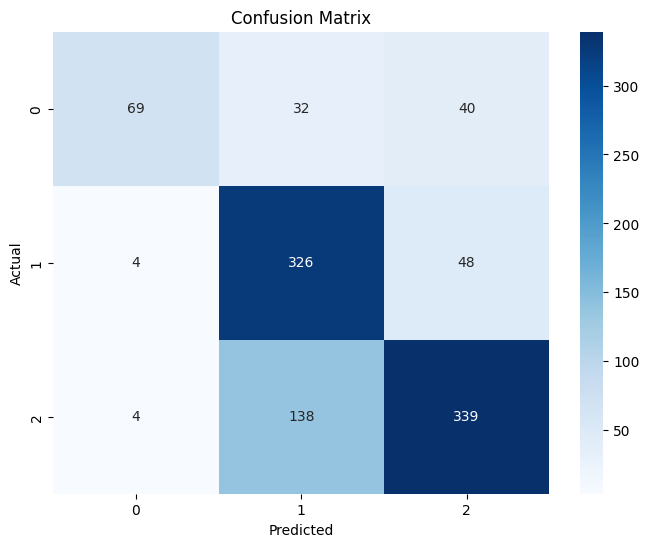

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

confusion = confusion_matrix(actual_labels, predicted_labels)

plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt='d', cmap='Blues', xticklabels=True, yticklabels=True)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()